In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
from nm_lib import nm_lib as nm
import importlib
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import scipy.optimize
importlib.reload(nm)

<module 'nm_lib.nm_lib' from '/home/astronih/Documents/nm_lib/nm_lib/nm_lib.py'>

Will solve the following equations in one dimension

$$ \frac{\partial \rho}{\partial t} + \nabla \cdot (\rho \bf u) = 0 $$

$$ \frac{\partial \rho {\bf u}}{\partial t} + \nabla \cdot (\rho {\bf u} \otimes {\bf u}) = - \nabla (P_g)$$

$$ \frac{\partial e}{\partial t } = -\nabla\cdot e {\bf u} -P_g \nabla \cdot {\bf u}$$

Following then the continuity equation in 1D

$$
\begin{align}
\frac{\partial \rho}{\partial t} &= -\frac{\partial \rho u}{\partial x} \\
\end{align}
$$

But in order to solve this we must first numerically solve $\frac{\partial \rho u}{\partial x}$

$$
\begin{align}
\frac{\partial \rho u}{\partial x} &= \left(u \frac{\partial \rho}{\partial x} + \rho \frac{\partial u}{\partial x}\right)
\end{align}
$$
And the LHS becomes
$$
\begin{align}
\frac{\partial \rho}{\partial t} = \frac{\rho^{n+1} - \rho^n}{\Delta t}
\end{align}
$$
Then 
$$
\rho^{n+1} = \rho^n - \Delta t \left(u^n \left[\frac{\partial \rho}{\partial x}\right]^n + \rho^n \left[\frac{\partial u}{\partial x}\right]^n\right)
$$
Where the brackets represent the derivative scheme, which is going to be dependent on the flow direction

Now for the momentum equation

$$
\begin{align}
\frac{\partial (\rho \mathbf{u})}{\partial t} + \nabla \cdot (\rho \mathbf{u} \otimes \mathbf{u}) = -\nabla (P_g)
\end{align}
$$
In one dimension we have then
$$
\begin{align}
\frac{\partial (\rho u)}{\partial t} + \frac{\partial \left(\rho u^2\right)}{\partial x} = -\frac{\partial}{\partial x} (P_g)
\end{align}
$$

We have already done the first term, so the second term with the help of product rule becomes
$$
\begin{align}
\frac{\partial \left(\rho u^2\right)}{\partial x} &= \rho u \frac{\partial u}{\partial x} + u\frac{\partial (\rho u)}{\partial x}
\end{align}
$$
This turns the momentum equation into
$$
\begin{align}
\frac{\partial (\rho u)}{\partial t} + \rho u \frac{\partial u}{\partial x} + u\frac{\partial (\rho u)}{\partial x}= -\frac{\partial}{\partial x} (P_g)
\end{align}
$$
Discretized
$$
\begin{align}
\left[\frac{\partial (\rho u)}{\partial t}\right]^n =- \left[\rho u\right]^n \left[\frac{\partial u}{\partial x}\right]^n - u^n\left[\frac{\partial (\rho u)}{\partial x}\right]^n-\left[\frac{\partial}{\partial x} (P_g)\right]^n
\end{align}
$$
But this is also aprroximated to
$$
\left[\frac{\partial \rho u}{\partial t}\right]^n \approx \frac{\left[\rho u\right]^{n+1} - \left[\rho u\right]^n}{\Delta t}
$$
Meaning we get
$$
u^{n+1} = \frac{\left[\rho u\right]^n + \left[\frac{\partial \rho u}{\partial t}\right]^n \Delta t}{\rho^{n+1}}\
$$
Where again we must be carefull of which scheme to use on $\frac{\partial \rho u}{\partial t}$

Lastly the energy equation

$$
\frac{\partial e}{\partial t} = - \frac{\partial (eu)}{\partial x} - P\frac{\partial u}{\partial x}
$$
RHS turns into
$$
-\frac{\partial (eu)}{\partial x} - P\frac{\partial u}{\partial x} = -(e + P) \frac{\partial u}{\partial x} - u\frac{\partial e}{\partial x}
$$
So energy
$$
e^{n+1} = e^n + \left[\frac{\partial e}{\partial t}\right]^n \Delta t
$$

Only LAX method in Julia, start with implenting just Python.

Hint from tor. Make Lax in SOD Laxer

1/3 * (np.roll(rho*uy, -1) +rho*uy + np.roll(rho*uy, +1)) + rhs * dt

In [3]:
def e_step(xx, uu, e, Pg, dt):
    """
    Returns the e^{n+1} in the energy equation

    Dependencies:
    -------------
    nm_lib:
    deriv_upw
    deriv_dnw
    deriv_cent
    
    Parameters
    ----------
    xx : `array`
        Spatial axis.
    hh : `array`
        Function that depends on xx.
    e   : `array`
        Energy function that depends on xx
    Pg  : `array`
        Pressure function that depend on xx
    dt  : `float`
        Time step

    Returns
    -------
    The right hans side of the equation for e^{n+1}
    """
    # Implementing the upwind and downwind in one line
    term1 = nm.deriv_upw(xx, e)
    term2 = nm.deriv_dnw(xx, e)
    if np.any(uu>=0):
        term1 = term1[np.where(uu>=0)]
    else:
        term1 = np.zeros_like(term2)
    if np.any(uu<0):
        term2 = term2[np.where(uu<0)]
    else:
        term2 = np.zeros_like(term1)
        
    ddx_e = term1 + term2
    
    # Calculate the derivative
    ddt_e = -(e + Pg)*nm.deriv_cent(xx, uu) - uu*ddx_e
    ennt = e + ddt_e*dt
    return ennt
    
def rho_step(xx, uu, rho, dt):
    """
    Returns the rho^{n+1} in the momentum equation

    Dependencies:
    -------------
    nm_lib:
    deriv_upw
    deriv_dnw
    deriv_cent
    
    Parameters
    ----------
    xx : `array`
        Spatial axis.
    rho : `array`
        Density function that depends on xx
    dt  : `float`
        Time step

    Returns
    -------
    The right hans side of the equation for rho^{n+1}
    """
    term1 = nm.deriv_upw(xx, rho) #[np.where(uu>=0)]
    term2 = nm.deriv_dnw(xx, rho) #[np.where(uu<0)]
    if np.any(uu>=0):
        term1 = term1[np.where(uu>=0)]
    else:
        term1 = np.zeros_like(term2)
    if np.any(uu<0):
        term2 = term2[np.where(uu>=0)]
    else:
        term2 = np.zeros_like(term1)
    ddx_rho = term1 + term2
    ddx_u = nm.deriv_cent(xx, uu)
    rho_nnt = rho - dt*(uu*ddx_rho + rho*ddx_u)
    # Avijeet did something smart
    return rho_nnt
    
def lax_method(xx, hh, dt, dx, bnd_limits=[0, 1], bnd_type="wrap"):
    N = len(xx)
    ans = np.zeros(N)
    term1 = np.roll(hh, -1) + np.roll(hh, 1)
    term2 = np.roll(hh, -1) - np.roll(hh, 1)
    frac = (hh*dt) / (2*dx)
    tmmp = 0.5*term1 - frac*term2
    # For upwind and centre
    if bnd_limits[1] > 0:
        ans = np.pad(tmmp[bnd_limits[0]: -bnd_limits[1]], bnd_limits, bnd_type)
    # For downwind
    else:
        ans = np.pad(tmmp[bnd_limits[0]:], bnd_limits, bnd_type)
    return ans


def ddt_rhou(xx, uu, P, rhou):
    """
    Returns the rhs for the ddt_rhou equation

    Dependencies:
    -------------
    nm_lib:
    deriv_upw
    deriv_dnw
    deriv_cent
    
    Parameters
    ----------
    xx : `array`
        Spatial axis.
    hh : `array`
        Function that depends on xx.
    P : `array`
        Pressure function that depends on xx
    rhou : `array`
        Momentum function that depends on xx

    Returns
    -------
    The right hans side of the equation for rho^{n+1}
    """
    ddx_u = nm.deriv_cent(xx, uu)
    term1 = nm.deriv_upw(xx, rhou)
    term2 = nm.deriv_dnw(xx, rhou)
    if np.any(uu>=0):
        term1 = term1[np.where(uu>=0)]
    else:
        term1 = np.zeros_like(term2)
    if np.any(uu<0):
        term2 = term2[np.where(uu>=0)]
    else:
        term2 = np.zeros_like(term1)
    ddx_rhou = term1 + term2
    ddx_P = nm.deriv_cent(xx, P)
    
    ans = -rhou*ddx_u - uu*ddx_rhou - ddx_P
    return ans

def u_step(xx, uu, rho, P, dt):
    """
    Parameters
    ----------
    xx : `array`
        Spatial axis.
    hh : `array`
        Function that depends on xx.

    Returns
    -------
    """
    rhou = rho*uu
    dd_rhou = ddt_rhou(xx, uu, P, rhou)
    rho_nnt = rho_step(xx, uu, rho, dt)
    
    unnt = (rhou + dd_rhou*dt)/rho_nnt 
    return unnt
    
def bifrost_6th(xx, hh):
    c = 3/640
    b = 1/24 - 3*c
    a = 1 - 3*b + 5*c

    dx = np.gradient(xx)

    term1 = a/dx*(hh - np.roll(hh, -1))
    term2 = b/dx*(np.roll(hh, 1) - np.roll(hh, -2))
    term3 = c/dx*(np.roll(hh, 2) - np.roll(hh, -3))
    
    rhs = term1 + term2 + term3
    return rhs
    
def flux_limiter(xx, hh, lamba):
    """Lax simple scheme"""
    pass

def P(e, rho, γ=5/3):
    """
    Calculates the Pressure

    Parameters:
    -----------
    e
    """
    prod = e#/rho
    ans = (γ - 1)*prod
    return ans

def initialise(nx, ny, nz, nt, P0, rho0, γ=5/3):

    if (ny == 1) and (nz == 1):
        N = nx
    else:
        N = (nx, ny, nz)
    Pg = np.zeros((N, nt))
    rho = np.zeros((N, nt))
    u = np.zeros((N, nt))
    moment = np.zeros((N, nt))
    e = np.zeros((N, nt))
    
    Pg[0:int(nx/2), 0] = P0[0]
    Pg[int(nx/2):, 0] = P0[1]

    rho[0:int(nx/2), 0] = rho0[0]
    rho[int(nx/2):, 0] = rho0[1]
    
    e[:, 0] = Pg[:, 0]/(γ - 1)
    
    return Pg, rho, e, moment
    
def calc_dt(cs, u, xx, cfl_cut=0.98):
    dt1 = cfl_cut*nm.cfl_adv_burger(u + cs, xx)
    dt2 = cfl_cut*nm.cfl_adv_burger(u, xx)
    return np.min([dt1, dt2])

def calculate_cs(P, rho, γ, eps=1e-10):
    cs = np.sqrt(γ*P/(rho + eps))
    return cs
    

def init_array(nx, nt, P0, rho0, u0, e0, γ=5/3):
    e = np.zeros((nx, nt)) 
    Pg = np.zeros((nx, nt))   
    moment = np.zeros((nx, nt))
    rho = np.zeros((nx, nt))
    u = np.zeros((nx, nt))
    
    e[:, 0] = e0
    Pg[:, 0] = P0
    rho[:, 0] = rho0
    u[:, 0] = u0
    moment[:, 0] = u0*rho0
    return Pg, e, moment, rho, u

# TODO combine init_array and init_array3D to one
def init_array3D(nx, ny, nz, nt, P0, rho0, u0, e0, γ=5/3):
    e = np.zeros((nx, ny, nz,  nt)) 
    Pg = np.zeros((nx, ny, nz,  nt))   
    moment = np.zeros((nx, ny, nz,  nt))
    rho = np.zeros((nx, ny, nz,  nt))
    u = np.zeros((nx, ny, nz,  nt))
    
    idx = (..., 0)
    
    e[idx] = e0
    Pg[idx] = P0
    rho[idx] = rho0
    u[idx] = u0
    moment[idx] = u0*rho0
    return Pg, e, moment, rho, u
    
def solver3D(nx, ny, nz, xx, yy, nt, P0, rho0, u0, e0,
             γ=5/3, cfl_cut=0.2, ddx=lambda x, y: nm.deriv_dnw(x, y),
             method='FTCS', bnd_type='wrap', bnd_limits=[0, 1]):
    Pg, e, moment, rho, u = init_array(nx, ny, nz, nt, P0, rho0, u0, e0, γ=γ)
    time = np.zeros(nt)
    eps = 1e-10
    for i in range(0, nt-1):
        idx = (..., i)
        u = moment[idx]/(rho[idx] + eps)
        Pg_temp = Pg[idx]

        cs = np.sqrt(γ * Pg_temp/(rho[idx] + eps))
        
        #cfl condition
        dt1 = np.min(np.gradient(xx)/ np.abs(u + eps))
        dt2 = np.min(np.gradient(xx)/ np.abs(u - cs + eps))
        dt3 = np.min(np.gradient(xx)/ np.abs(u + cs + eps))
        dt = cfl_cut*np.min([dt1, dt2, dt3])
        if method == 'FTCS':
            rho_rhs = - ddx(xx, rho[idx] * u)
            moment_rhs = -ddx(xx, moment[idx]*u + Pg_temp)
            e_rhs = - ddx(xx, e[idx] * u) - Pg_temp*ddx(xx, u)
            
            rho_temp = rho[idx] + rho_rhs*dt
            moment_temp = moment[idx] + moment_rhs*dt
            e_temp = e[idx] + e_rhs*dt
        
        elif method == 'LAX':
            rho_lax = (np.roll(rho[idx], -1) + rho[idx] + np.roll(rho[idx], 1))/ 3.
            moment_lax = (np.roll(moment[idx], -1) + moment[idx] + np.roll(moment[idx], 1))/ 3.
            e_lax = (np.roll(e[idx], -1) + e[idx] + np.roll(e[idx], 1))/ 3.

            rho_rhs =  -ddx(xx, rho[idx] * u)
            moment_rhs = -ddx(xx, moment[idx]*u + Pg_temp)
            e_rhs =  -ddx(xx, e[idx] * u) - Pg_temp*ddx(xx, u)
            
            rho_temp = rho_lax + rho_rhs*dt
            moment_temp = moment_lax + moment_rhs*dt
            e_temp = e_lax + e_rhs*dt
            
            
        # Boundary conditions
        if bnd_limits[1] > 0: # up and centre
            rho_bc = rho_temp[bnd_limits[0]: -bnd_limits[1]]
            moment_bc = moment_temp[bnd_limits[0]: -bnd_limits[1]]
            e_bc = e_temp[bnd_limits[0]: -bnd_limits[1]]
        else:
            rho_bc = rho_temp[bnd_limits[0]:]
            moment_bc = moment_temp[bnd_limits[0]:]
            e_bc = e_temp[bnd_limits[0]:]
            
        # Variable update
        idx_next = (..., i+1)
        rho[idx_next] = np.pad(rho_bc, bnd_limits, bnd_type)
        moment[idx_next] = np.pad(moment_bc, bnd_limits, bnd_type)
        e[idx_next] = np.pad(e_bc, bnd_limits, bnd_type)
        Pg_temp = (γ - 1)*e[idx_next]
        Pg[idx_next] = Pg_temp
        
        time[i+1] = time[i] + dt
        
    return Pg, rho, moment, e, time

def solver(nx, ny, nz, xx, nt, P0, rho0, u0=None, e0=None, 
           γ=5/3, cfl_cut=0.2,
           ddx=lambda x, y: nm.deriv_dnw(x, y), method='FTCS', 
           bnd_type='wrap', bnd_limits=[0,1], sod=None):
    """
    Need sound speed
    """
    Pg, e, moment, rho, u = init_array(nx, nt, P0, rho0, u0, e0, γ=γ)
    print(Pg.shape)
    time = np.zeros(nt)
    eps = 1.e-10
    for i in range(0, nt-1):
        u = moment[:, i] / (rho[:, i] + eps)
        Pg_temp = Pg[:, i]
        cs = np.sqrt(γ * Pg_temp/(rho[:, i] + eps))
        
        #cfl condition
        dt = cfl_cut*np.min(np.gradient(xx)/ (np.abs(u) + cs + eps))
        if method == 'FTCS':
            rho_rhs = - ddx(xx, rho[:, i] * u)
            moment_rhs = -ddx(xx, moment[:, i]*u + Pg_temp)
            e_rhs = - ddx(xx, e[:, i] * u) - Pg_temp*ddx(xx, u)
            
            rho_temp = rho[:, i] + rho_rhs*dt
            moment_temp = moment[:, i] + moment_rhs*dt
            e_temp = e[:, i] + e_rhs*dt
        
        elif method == 'LAX':
            rho_lax = (np.roll(rho[:, i], -1) + rho[:, i] + np.roll(rho[:, i], 1))/ 3.
            moment_lax = (np.roll(moment[:, i], -1) + moment[:, i] + np.roll(moment[:, i], 1))/ 3.
            e_lax = (np.roll(e[:, i], -1) + e[:, i] + np.roll(e[:, i], 1))/ 3.

            rho_rhs =  -ddx(xx, rho[:, i] * u)
            moment_rhs = -ddx(xx, moment[:, i]*u + Pg_temp)
            e_rhs =  -ddx(xx, e[:, i] * u) - Pg_temp*ddx(xx, u)
            
            rho_temp = rho_lax + rho_rhs*dt
            moment_temp = moment_lax + moment_rhs*dt
            e_temp = e_lax + e_rhs*dt
            
            
        # Boundary conditions
        if bnd_limits[1] > 0: # up and centre
            rho_bc = rho_temp[bnd_limits[0]: -bnd_limits[1]]
            print(rho_bc.shape)
            moment_bc = moment_temp[bnd_limits[0]: -bnd_limits[1]]
            e_bc = e_temp[bnd_limits[0]: -bnd_limits[1]]
        else:
            rho_bc = rho_temp[bnd_limits[0]:]
            moment_bc = moment_temp[bnd_limits[0]:]
            e_bc = e_temp[bnd_limits[0]:]
            
        # Variable update
        rho[:, i+1] = np.pad(rho_bc, bnd_limits, bnd_type)
        moment[:, i+1] = np.pad(moment_bc, bnd_limits, bnd_type)
        e[:, i+1] = np.pad(e_bc, bnd_limits, bnd_type)
        Pg_temp = (γ - 1)*e[:, i+1]
        Pg[:, i+1] = Pg_temp
        
        time[i+1] = time[i] + dt
        
        
    return Pg, rho, moment, e, time
    

def gauss(xx, A, mu, sigma, C):
    ans = A*np.exp(-.5*(xx - mu)**2/sigma**2) + C
    return ans

In [4]:
def animation(xx, tt, ut, rhot, Pgt, nt, figsize=(10, 5)):
    fig, axes = plt.subplots(1, 1, figsize=figsize)
    def init():
        axes.plot(xx, ut[:, 0], label='u')
        axes.plot(xx, rhot[:, 0], label='rho')
        axes.plot(xx, Pgt[:, 0], label='P')
        axes.set_ylim(-0.1, 1.1)
        axes.set_xlim(min(xx), max(xx))
        axes.legend()
    
    def animate(i):
        axes.clear()
        axes.plot(xx, ut[:, i], label='u')
        axes.plot(xx, rhot[:, i], label='rho')
        axes.plot(xx, Pgt[:, i], label='P')
        axes.set_ylim(-0.1, 1.1)
        axes.set_xlim(min(xx), max(xx))
        axes.legend()
        axes.set_title(f't={tt[i]:.2f}')
        
    anim = FuncAnimation(fig, animate, interval=1, frames=nt, init_func=init)
    return anim

Test with gaussian profile

In [5]:
γ = 5/3
nt = 100
nx = 64
ny, nz = 1, 1
xx = nm.spatial_domain(nx, x0=0, xf=1)

In [6]:
u0 = np.zeros(nx)+0.01
e0 = gauss(xx, 1, 0.5, sigma=0.01, C=0.1)#np.exp(-(xx-xx[nx2])**2/(2*0.1)) + 0.1
Pg0 = (γ - 1)*e0 
rho0 = np.ones(nx)#gauss(xx, 1, 0.5, sigma=0.01, C=0.1)#np.exp(-(xx-xx[nx2])**2/(2*0.01)) + 0.1

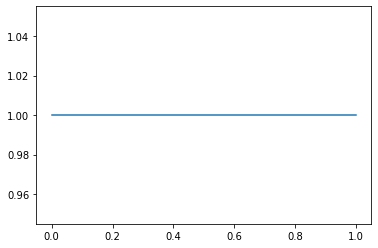

In [7]:
plt.plot(xx, rho0)

In [8]:
Pg1D, rho1D, moment1D, e1D, time1D = solver(nx, ny, nz, xx, nt, Pg0, rho0, u0, e0, method='LAX')
u1D = moment1D/rho1D

(64, 100)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)
(63,)


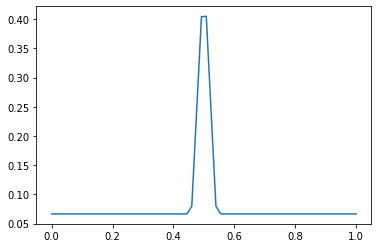

In [9]:
plt.plot(xx, Pg1D[:, 1])

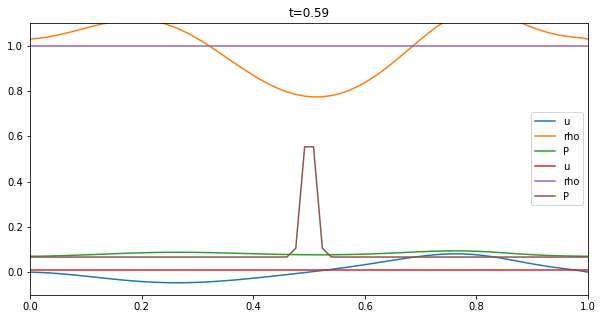

In [10]:
anim = animation(xx, time1D, u1D, rho1D, Pg1D, nt)
HTML(anim.to_jshtml())

In [11]:
nx = 1024
γ = 5/3
xx = nm.spatial_domain(nx, x0=0., xf=1.)
nx2 = int(nx/2)
ny, nz = 1, 1
nt = 100

PL = 1.0
PR = 0.1
u0 = np.zeros(nx)+0.01
e0 = np.zeros(nx)+0.01
e0[:nx2] = PL/(γ - 1)
e0[nx2:] = PR/(γ - 1)

rho0 = np.zeros(nx)
Pg0 = (γ - 1)*e0
rho0[:nx2] = 1.0
rho0[nx2:] = 0.125

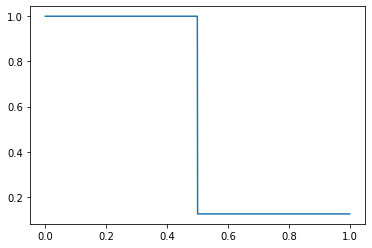

In [12]:
plt.plot(xx, rho0)

In [13]:
Pg, rho, moment, e, time= solver(nx, ny, nz, xx, nt, Pg0, rho0, u0, e0, method='LAX')

(1024, 100)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)
(1023,)


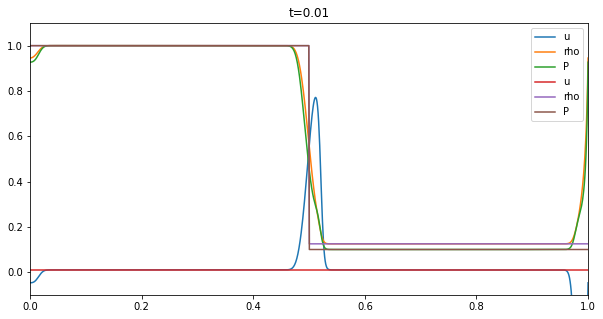

In [14]:
u = moment/rho
anim = animation(xx, time, u, rho, Pg, nt)
HTML(anim.to_jshtml())

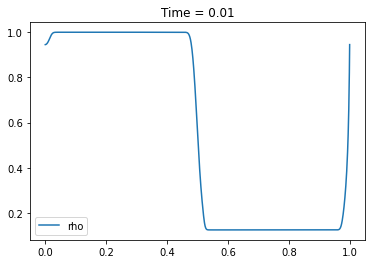

In [15]:
value = 0.2

t_idx = np.abs(time - value).argmin()
plt.plot(xx, rho[:, t_idx], label='rho')
plt.title(f'Time = {time[t_idx]:.2f}')
plt.legend()
plt.show()

In [16]:
x_sod, P_sod, rho_sod, u_sod, t_sod = nm.solve_sod_array(t_end=0.2, nt=100)

In [17]:
#anim = nm.animate_sod(x_sod, P_sod, rho_sod, u_sod, t_sod)
#HTML(anim.to_jshtml())

# Implementing several dimensions

In [28]:
def init_array3D(domain, nt, P0, rho0, u0, e0, γ=5/3):
    nx, ny, nz = domain
    e = np.zeros((nx, ny, nz, nt))
    Pg = np.zeros((nx, ny, nz, nt))
    moment = np.zeros((nx, ny, nz, nt))
    rho = np.zeros((nx, ny, nz, nt))
    u = np.zeros((nx, ny, nz, nt))

    e[:, :, :, 0] = e0
    Pg[:, :, :, 0] = P0
    rho[:, :, :, 0] = rho0
    u[:, :, :, 0] = u0
    moment[:, :, :, 0] = u0*rho0
    return Pg, e, moment, rho, u


def find_nan(arr, title, i):
    """
    Looks for nan values and breaks the loop
    """
    if np.any(np.isnan(arr)):
        print(f'{title} is nan at i: {i}')
        print(arr)


def calculate_dt(xx, yy, zz, u, cs, eps, nx, ny, nz, debug=False):
    if nx > 1:
        a = np.min(np.gradient(xx)) / np.max(np.abs(u) + cs + eps)
    else:
        a = np.array([100])
    if nz > 1:
        c = np.min(np.gradient(zz)) / np.max(np.abs(u) + cs + eps)
    else:
        c = np.array([100])
    if ny > 1:
        b = np.min(np.gradient(yy)) / np.max(np.abs(u) + cs + eps)
    else:
        b = np.array([100])
    ans = np.min([a, b, c])
    if debug:
        print(f'max u : {np.max(u)}')
        print(f'max cs : {np.max(cs)}')
    return ans


def init_arrayND(domain, nt, P0, rho0, u0, e0, γ=5/3):
    nx, ny, nz = domain
    if nx != ny and ny == 1 and nz == 1: 
        idx = (slice(None), 0)
        
    elif nx == ny and ny == nz:
        idx = (slice(None), slice(None), slice(None), 0)

    e = np.zeros((*domain, nt))
    Pg = np.zeros((*domain, nt))
    moment = np.zeros((*domain, nt))
    rho = np.zeros((*domain, nt))
    u = np.zeros((*domain, nt))

    e[idx] = e0
    Pg[idx] = P0
    rho[idx] = rho0
    u[idx] = u0
    moment[idx] = u0*rho0

    return Pg, e, moment, rho, u


def solverND(domain, xx, yy, zz, nt, P0, rho0, u0, e0,
             γ=5/3, cfl_cut=0.2, ddx=lambda x, y: nm.deriv_dnw(x, y),
             method='FTCS', bnd_type='wrap', bnd_limits=[0, 1], debug=False):
    newax = np.newaxis
    nx, ny, nz = domain
    Pg, e, moment, rho, u = init_arrayND(domain, nt, P0, rho0, u0, e0, γ=γ)
    time = np.zeros(nt)
    eps = 1e-10
    cs_list = []

    rho_rhs = np.zeros((domain))
    moment_rhs = np.zeros((domain))
    e_rhs = np.zeros((domain))

    for i in range(0, nt-1):
        # For easier indexing
        if ny == 1 and nz == 1:
            idx = (slice(None), i)
            idx_x = (slice(None), slice(None), slice(None), i)
            idx_y = idx
            idx_z = idx
            idx_xx = slice(None)
            idx_yy = None
            idx_next = (slice(None), i+1)

        else:
            idx = (slice(None), slice(None), slice(None), i)
            idx_xx = (slice(None), 0, 0)
            idx_yy = (0, slice(None), 0)
            idx_zz = (0, 0, slice(None))
            idx_x = (slice(None), 0, 0, i)
            idx_y = (0, slice(None), 0, i)
            idx_z = (0, 0, slice(None), i)
            idx_next = (slice(None), slice(None), slice(None), i+1)
        """
        idx = (slice(None), slice(None), slice(None), i)
        idx_xx = (slice(None), 0, 0)
        idx_yy = (0, slice(None), 0)
        idx_zz = (0, 0, slice(None))
        idx_x = (slice(None), 0, 0, i)
        idx_y = (0, slice(None), 0, i)
        idx_z = (0, 0, slice(None), i)
        idx_next = (slice(None), slice(None), slice(None), i+1)

        """
        u = moment[idx]/(rho[idx] + eps)
        if nx == ny and nx == nz:
            ux = moment[idx_x]/(rho[idx_x] + eps)
            uy = moment[idx_y]/(rho[idx_y] + eps)
            uz = moment[idx_z]/(rho[idx_z] + eps)
            
        else:
            ux = u
            uy = np.array([0.])
            uz = np.array([0.])
        Pg_temp = Pg[idx]
        num = γ*Pg_temp
        den = rho[idx] + eps
        arg = num/den
        cs = np.sqrt(arg)

        find_nan(rho[idx], 'rho', i)
        find_nan(Pg_temp, 'Pg', i)
        find_nan(num, 'num', i)
        find_nan(den, 'den', i)
        find_nan(arg, 'arg', i)
        find_nan(cs, 'cs', i)

        # cfl condition
        dt = cfl_cut*np.min(calculate_dt(xx, yy, zz, u, cs, eps, nx, ny, nz))
        if dt < 0:
            print(f'dt negative: {i}')
            break
        find_nan(dt, 'dt', i)
        if debug:
            print(f'ux: {ux.shape}')
            print(f'uy: {uy.shape}')
            print(f'uz: {uz.shape}')
            print(f'yy: {yy.shape}')
            #print(f'{yy}')
            print(f'rho: {rho[0, :, 0, i].shape}')
            print(f'cs: {cs.shape}')
            print(f'dt: {dt}')
            print(f'min num : {np.min(num)}')
            print(f'min den : {np.min(den)}')
            print(f'min arg : {np.min(arg)}')
            print(f'min cs : {np.min(cs)}')
        if method == 'FTCS':
            if debug:
                print(f'rho[idx_x] shape: {rho[idx_x].shape}')
                print(f'rho[idx_y] shape: {rho[idx_y].shape}')
                print(f'rho[idx_z] shape: {rho[idx_z].shape}')
                print(f'ux shape: {ux.shape}')
                print(f'uy shape: {uy.shape}')
                print(f'uz shape: {uz.shape}')
                print(f'Pg_temp[idx_xx] shape: {Pg_temp[idx_xx].shape}')
                print(f'xx shape: {xx.shape}')
                print(f'yy shape: {yy.shape}')
                print(f'zz shape: {zz.shape}')
                print(f'moment_rhs[idx_yy] : {moment_rhs[idx_yy].shape}')


            # Split the operations into many if statements
            # because need to check the value for nN
            if nx > 1:
                rho_rhs[idx_xx] = -ddx(xx, rho[idx_x]*ux)
            if ny > 1:
                rho_rhs[idx_yy] = -ddx(yy, rho[idx_y]*uy)
            if nz > 1:
                rho_rhs[idx_zz] = -ddx(zz, rho[idx_z]*uz)


            # TODO the calculations on the right side has array length 64

            # This is okey, because left side (64,) and right side (64,)
            moment_rhs_x = 0.
            moment_rhs_y = 0. 
            moment_rhs_z = 0.
            if nx > 1:
                moment_rhs_x += -(ddx(xx, rho[idx_x]*ux*ux) + ddx(xx, Pg_temp[idx_xx]))
                moment_rhs_y += -(ddx(xx, rho[idx_x]*uy*uy))
                moment_rhs_z += -(ddx(xx, rho[idx_x]*uz*uz))
            if ny > 1:
                moment_rhs_x += -(ddx(yy, rho[idx_y]*ux*uy))
                moment_rhs_y += -(ddx(yy, rho[idx_y]*ux*uy) + ddx(yy, Pg_temp[idx_yy]))
                moment_rhs_z += -(ddx(yy, rho[idx_y]*uy*uz))
            if nz > 1:
                moment_rhs_x += -(ddx(zz, rho[idx_z]*ux*uz))
                moment_rhs_y += -(ddx(zz, rho[idx_z]*uz*uy))
                moment_rhs_z += -(ddx(zz, rho[idx_z]*ux*uz) + ddx(zz, Pg_temp[idx_zz]))
                
                
            if nx != ny and ny == nz:
                moment_rhs[idx_xx] = moment_rhs_x
                
            elif nx == ny and nx != nz:
                moment_rhs[idx_xx] = moment_rhs_x
                moment_rhs[idx_yy] = moment_rhs_y
            else:
                moment_rhs[idx_xx] = moment_rhs_x
                moment_rhs[idx_yy] = moment_rhs_y
                moment_rhs[idx_zz] = moment_rhs_z


            if nx > 1:
                e_rhs[idx_xx] = -(ddx(xx, e[idx_x]*ux) -
                                  Pg_temp[idx_xx]*ddx(xx, ux))
            if ny > 1:
                e_rhs[idx_yy] = -(ddx(yy, e[idx_y]*uy) -
                                  Pg_temp[idx_yy]*ddx(yy, uy))
            if nz > 1:
                e_rhs[idx_zz] = -(ddx(zz, e[idx_z]*uz) -
                                  Pg_temp[idx_zz]*ddx(zz, uz))

            rho_temp = rho[idx] + rho_rhs*dt
            moment_temp = moment[idx] + moment_rhs*dt
            e_temp = e[idx] + e_rhs*dt

            if np.any(np.isnan(rho_temp)):
                print(f'rho_temp nan at i: {i}')
                print(rho_temp)
                return Pg, rho, moment, e, time

        # Boundary conditions
        if nx > 1:
            if bnd_limits[1] > 0:  # up and centre
                rho_bc_x = rho_temp[idx_xx][bnd_limits[0]: -bnd_limits[1]]
                moment_bc_x = moment_temp[idx_xx][bnd_limits[0]: -bnd_limits[1]]
                e_bc_x = e_temp[idx_xx][bnd_limits[0]: -bnd_limits[1]]
            else:
                rho_bc_x = rho_temp[bnd_limits[0]:]
                moment_bc_x = moment_temp[bnd_limits[0]:]
                e_bc_x = e_temp[bnd_limits[0]:]
        else:
            rho_bc_x = 0
            moment_bc_x = 0
            e_bc_x = 0
        if ny > 1:        
            if bnd_limits[1] > 0:  # up and centre
                rho_bc_y = rho_temp[idx_yy][bnd_limits[0]: -bnd_limits[1]]
                moment_bc_y = moment_temp[idx_yy][bnd_limits[0]: -bnd_limits[1]]
                e_bc_y = e_temp[idx_yy][bnd_limits[0]: -bnd_limits[1]]
            else:
                rho_bc = rho_temp[bnd_limits[0]:]
                moment_bc = moment_temp[bnd_limits[0]:]
                e_bc = e_temp[bnd_limits[0]:]
        else:
            rho_bc_y = 0
            moment_bc_y = 0
            e_bc_y = 0
        if nz > 1:
            if bnd_limits[1] > 0:  # up and centre
                rho_bc_z = rho_temp[idx_zz][bnd_limits[0]: -bnd_limits[1]]
                moment_bc_z = moment_temp[idx_zz][bnd_limits[0]: -bnd_limits[1]]
                e_bc_z = e_temp[idx_zz][bnd_limits[0]: -bnd_limits[1]]
            else:
                rho_bc = rho_temp[bnd_limits[0]:]
                moment_bc = moment_temp[bnd_limits[0]:]
                e_bc = e_temp[bnd_limits[0]:]
        else:
            rho_bc_z = 0
            moment_bc_z = 0
            e_bc_z = 0

        rho_bc = np.zeros((nx-1, ny-1, nz-1))  # Initialize boundary condition array
        moment_bc = np.zeros((nx-1, ny-1, nz-1))
        e_bc = np.zeros((nx-1, ny-1, nz-1))
        # Assign boundary conditions based on dimensions
        rho_bc[:, 0, 0] = rho_bc_x
        moment_bc[:, 0, 0] = moment_bc_x
        e_bc[:, 0, 0] = e_bc_x

        if ny > 1:
            rho_bc[0, :, 0] = rho_bc_y
            moment_bc[0, :, 0] = moment_bc_y
            e_bc[0, :, 0] = e_bc_y

        if nz > 1:
            rho_bc[0, 0, :] = rho_bc_z
            moment_bc[0, 0, :] = moment_bc_z
            e_bc[0, 0, :] = e_bc_z
            
        

        # Variable update
        rho[idx_next] = np.pad(rho_bc, bnd_limits, bnd_type)
        if np.any(np.isnan(rho[idx_next])):
            print(f'rho nan value i: {i}')
        moment[idx_next] = np.pad(moment_bc, bnd_limits, bnd_type)
        e[idx_next] = np.pad(e_bc, bnd_limits, bnd_type)

        Pg_temp = (γ - 1) * e[idx_next]
        if np.any(np.isnan(Pg_temp)):
            print(f'Pg nan value i: {i}')
            return Pg, rho, moment, e, time
        Pg[idx_next] = Pg_temp

        time[i+1] = time[i] + dt

    return Pg, rho, moment, e, time


def solver3D(domain, xx, yy, zz, nt, P0, rho0, u0, e0,
             γ=5/3, cfl_cut=0.2, ddx=lambda x, y: nm.deriv_dnw(x, y),
             method='FTCS', bnd_type='wrap', bnd_limits=[0, 1], debug=False):
    newax = np.newaxis
    allow = 0
    nx, ny, nz = domain
    Pg, e, moment, rho, u = init_array3D(domain, nt, P0, rho0, u0, e0, γ=γ)
    time = np.zeros(nt)
    eps = 1e-10
    cs_list = []

    rho_rhs = np.zeros((nx, ny, nz))
    moment_rhs = np.zeros((nx, ny, nz))
    e_rhs = np.zeros((nx, ny, nz))
    for i in range(0, nt-1):
        u = moment[:, :, :, i]/(rho[:, :, :, i] + eps)
        ux = moment[:, 0, 0, i]/(rho[:, 0, 0, i] + eps)
        uy = moment[0, :, 0, i]/(rho[0, :, 0, i] + eps)
        uz = moment[0, 0, :, i]/(rho[0, 0, :, i] + eps)
        Pg_temp = Pg[:, :, :, i]
        num = γ*Pg_temp
        den = rho[:, :, :, i] + eps
        arg = num/den
        cs = np.sqrt(arg)

        find_nan(rho[:, :, :, i], 'rho', i)
        find_nan(Pg_temp, 'Pg', i)
        find_nan(num, 'num', i)
        find_nan(den, 'den', i)
        find_nan(arg, 'arg', i)
        find_nan(cs, 'cs', i)

        # cfl condition
        #dt1 = np.min(calculate_dt(xx, yy, zz, u, cs0, eps, nx, ny, nz))

        dt = np.min(calculate_dt(xx, yy, zz, u, cs, eps, nx, ny, nz))

        #dt3 = np.min(calculate_dt(xx, yy, zz, u, -cs, eps, nx, ny, nz))

        #dt = cfl_cut*np.min([dt1, dt2, dt3])
        dt *= cfl_cut
        if dt < 0:
            print(f'dt negative: {i}')
            break
        find_nan(dt, 'dt', i)
        if debug:
            print(f'ux: {ux.shape}')
            print(f'uy: {uy.shape}')
            print(f'uz: {uz.shape}')
            print(f'yy: {yy.shape}')
            print(f'{yy}')
            print(f'rho: {rho[0, :, 0, i].shape}')
            print(f'cs: {cs.shape}')
            print(f'dt: {dt}')
            print(f'min num : {np.min(num)}')
            print(f'min den : {np.min(den)}')
            print(f'min arg : {np.min(arg)}')
            print(f'min cs : {np.min(cs)}')
        # For easier indexing
        idx = (slice(None), slice(None), slice(None), i)
        idx_xx = (slice(None), 0, 0)
        idx_yy = (0, slice(None), 0)
        idx_zz = (0, 0, slice(None))
        idx_x = (slice(None), 0, 0, i)
        idx_y = (0, slice(None), 0, i)
        idx_z = (0, 0, slice(None), i)
        if method == 'FTCS':

            rho_rhs[idx_xx] = -ddx(xx, rho[idx_x]*ux)
            rho_rhs[idx_yy] = -ddx(yy, rho[idx_y]*uy)
            rho_rhs[idx_zz] = -ddx(zz, rho[idx_z]*uz)

            if debug:
                print(f'rho[idx_x] shape: {rho[idx_x].shape}')
                print(f'rho[idx_y] shape: {rho[idx_y].shape}')
                print(f'rho[idx_z] shape: {rho[idx_z].shape}')
                print(f'ux shape: {ux.shape}')
                print(f'uy shape: {uy.shape}')
                print(f'uz shape: {uz.shape}')
                print(f'Pg_temp[idx_xx] shape: {Pg_temp[idx_xx].shape}')
                print(f'xx shape: {xx.shape}')
                print(f'yy shape: {yy.shape}')
                print(f'zz shape: {zz.shape}')
                print(f'moment_rhs[idx_yy] : {moment_rhs[idx_yy].shape}')

            # TODO the calculations on the right side has array length 64

            # This is okey, because left side (64,) and right side (64,)
            moment_rhs[idx_xx] = (-(ddx(xx, rho[idx_x]*ux*ux)
                                    + ddx(yy, rho[idx_y]*ux*uy)
                                    + ddx(zz, rho[idx_z]*ux*uz)
                                    + ddx(xx, Pg_temp[idx_xx])))
            # make if statements per spatial axis and nx
            # if nx > 1:
            # do ddx(xx, rhoux)

            # These is not okey, because left side (1,) and right side (64,)
            moment_rhs[idx_yy] = (-(ddx(yy, rho[idx_y]*ux*uy)
                                    + ddx(xx, rho[idx_x]*uy*uy)
                                    + ddx(zz, rho[idx_z]*uz*uy)
                                    + ddx(yy, Pg_temp[idx_yy])))
            moment_rhs[idx_zz] = (-(ddx(zz, rho[idx_z]*ux*uz)
                                    + ddx(yy, rho[idx_y]*uy*uz)
                                    + ddx(xx, rho[idx_x]*uz*uz)
                                    + ddx(zz, Pg_temp[idx_zz])))

            e_rhs[idx_xx] = -(ddx(xx, e[idx_x]*ux) -
                              Pg_temp[idx_xx]*ddx(xx, ux))

            e_rhs[idx_yy] = -(ddx(yy, e[idx_y]*uy) -
                              Pg_temp[idx_yy]*ddx(yy, uy))
            e_rhs[idx_zz] = -(ddx(zz, e[idx_z]*uz) -
                              Pg_temp[idx_zz]*ddx(zz, uz))

            rho_temp = rho[idx] + rho_rhs*dt
            moment_temp = moment[idx] + moment_rhs*dt
            e_temp = e[idx] + e_rhs*dt

            if np.any(np.isnan(rho_temp)):
                print(f'rho_temp nan at i: {i}')
                print(rho_temp)
                return Pg, rho, moment, e, time


        elif method == 'LAX':
            rho_lax = ((np.roll(rho[idx_x], -1) + rho[idx_x] + np.roll(rho[idx_x], 1))/3
                       + (np.roll(rho[idx_y], -1) +
                          rho[idx_y] + np.roll(rho[idx_y], 1))/3
                       + (np.roll(rho[idx_z], -1) + rho[idx_z] + np.roll(rho[idx_z], 1))/3)

            moment_lax = ((np.roll(moment[idx_x], -1) + moment[idx_x] + np.roll(moment[idx_x], 1))/3
                          + (np.roll(moment[idx_y], -1) +
                             moment[idx_y] + np.roll(moment[idx_y], 1))/3
                          + (np.roll(moment[idx_z], -1) + moment[idx_z] + np.roll(moment[idx_z], 1))/3)

            e_lax = ((np.roll(e[idx_x], -1) + e[idx_x] + np.roll(e[idx_x], 1))/3
                     + (np.roll(e[idx_y], -1) +
                        e[idx_y] + np.roll(e[idx_y], 1))/3
                     + (np.roll(e[idx_z], -1) + e[idx_z] + np.roll(e[idx_z], 1))/3)

            rho_rhs[idx_xx] = np.nan_to_num(-ddx(xx, rho[idx_x]*ux), nan=0)
            rho_rhs[idx_yy] = np.nan_to_num(-ddx(yy, rho[idx_y]*uy), nan=0)
            rho_rhs[idx_zz] = np.nan_to_num(-ddx(zz, rho[idx_z]*uz), nan=0)

            moment_rhs[idx_xx] = np.nan_to_num(-(ddx(xx, rho[idx_x]*ux*ux)
                                                 + ddx(yy, rho[idx_y]*ux*uy)
                                                 + ddx(zz, rho[idx_z]*ux*uz)
                                                 + ddx(xx, Pg_temp[idx_xx])), nan=0)
            moment_rhs[idx_yy] = np.nan_to_num(-(ddx(yy, rho[idx_y]*ux*uy)
                                                 + ddx(xx, rho[idx_x]*uy*uy)
                                                 + ddx(zz, rho[idx_z]*uz*uy)
                                                 + ddx(yy, Pg_temp[idx_yy])), nan=0)
            moment_rhs[idx_zz] = np.nan_to_num(-(ddx(zz, rho[idx_z]*ux*uz)
                                                 + ddx(yy, rho[idx_y]*uy*uz)
                                                 + ddx(xx, rho[idx_x]*uz*uz)
                                                 + ddx(zz, Pg_temp[idx_zz])), nan=0)
            e_rhs[idx_xx] = np.nan_to_num(-(ddx(xx, e[idx_x]*ux) -
                                          Pg_temp[idx_xx]*ddx(xx, ux)), nan=0)
            e_rhs[idx_yy] = np.nan_to_num(-(ddx(yy, e[idx_y]*uy) -
                                          Pg_temp[idx_yy]*ddx(yy, uy)), nan=0)
            e_rhs[idx_zz] = np.nan_to_num(-(ddx(zz, e[idx_z]*uz) -
                                          Pg_temp[idx_zz]*ddx(zz, uz)), nan=0)

            rho_temp = rho_lax + rho_rhs*dt
            moment_temp = moment_lax + moment_rhs*dt
            e_temp = e_lax + e_rhs*dt

            if np.any(np.isnan(rho_temp)):
                print(f'rho_temp nan at i: {i}')
                print(rho_temp)
                return Pg, rho, moment, e, time

        # Boundary conditions
        # pad per axis
        # if statement for x axis then bnd_limits
        #if nx > 1:

        if bnd_limits[1] > 0:  # up and centre
            rho_bc = rho_temp[bnd_limits[0]: -bnd_limits[1],
                              bnd_limits[0]:-bnd_limits[1], bnd_limits[0]:-bnd_limits[1]]
            moment_bc = moment_temp[bnd_limits[0]: -bnd_limits[1],
                                    bnd_limits[0]:-bnd_limits[1], bnd_limits[0]:-bnd_limits[1]]
            e_bc = e_temp[bnd_limits[0]: -bnd_limits[1], bnd_limits[0]:-bnd_limits[1], bnd_limits[0]:-bnd_limits[1]]
        else:
            rho_bc = rho_temp[bnd_limits[0]:]
            moment_bc = moment_temp[bnd_limits[0]:]
            e_bc = e_temp[bnd_limits[0]:]

        # Variable update
        rho[:, :, :, i+1] = np.pad(rho_bc, bnd_limits, bnd_type)
        if np.any(np.isnan(rho[:, :, :, i+1])):
            print(f'rho nan value i: {i}')
        moment[:, :, :, i+1] = np.pad(moment_bc, bnd_limits, bnd_type)
        e[:, :, :, i+1] = np.pad(e_bc, bnd_limits, bnd_type)
        """
        rho[:, :, :, i+1] = rho_temp
        moment[:, :, :, i+1] = moment_temp
        e[:, :, :, i+1] = e_temp
        """

        Pg_temp = (γ - 1) * e[:, :, :, i+1]
        if np.any(np.isnan(Pg_temp)):
            print(f'Pg nan value i: {i}')
            return Pg, rho, moment, e, time
        Pg[:, :, :, i+1] = Pg_temp

        time[i+1] = time[i] + dt

    return Pg, rho, moment, e, time


def gauss3D(xx, yy, zz, A, mu, sigma, C):
    x_term = -.5*(xx - mu[0])**2 / sigma[0]**2
    y_term = -.5*(yy - mu[1])**2 / sigma[1]**2
    z_term = -.5*(zz - mu[2])**2 / sigma[2]**2
    exponent = x_term + y_term + z_term
    ans = A * np.exp(exponent) + C
    return ans


## Testing on gaussian `(nx, 1, 1)`

In [34]:
γ = 5/3
nt = 100
nx, ny, nz = 64, 64, 64


domain = (nx, ny, nz)
xx = nm.spatial_domain(nx, x0=0, xf=1)#np.linspace(0, 1, nx)
yy = nm.spatial_domain(ny, x0=0, xf=1)
zz = nm.spatial_domain(nz, x0=0, xf=1)

u01D = np.zeros(nx)+0.01
e01D = gauss(xx, 1, 0.5, sigma=0.01, C=0.1)#np.exp(-(xx-xx[nx2])**2/(2*0.1)) + 0.1
Pg01D = (γ - 1)*e01D 
rho01D = np.ones(nx)#gauss(xx, 1, 0.5, sigma=0.01, C=0.1)#np.exp(-(xx-xx[nx2])**2/(2*0.01)) + 0.1

A = 1
#mu = [0.5, 0.5, 0.5]
#sigma = [0.1, 0.1, 0.1]
mu = 0.5
sigma = 0.01
C = 0.1

In [31]:
u0 = np.zeros((nx, ny, nz)) + 0.1
e0 = np.zeros((nx, ny, nz)) + 0.1
e0[:, 0, 0] = gauss(xx, A, mu, sigma, C)
#e0 = gauss3D(xx[:, np.newaxis, np.newaxis], yy, zz, 1, mu, sigma, C=0.1)
#e0 = e0.reshape(domain)
Pg0 = (γ - 1)*e0 
rho0 = np.ones((nx, ny, nz))
#rho0 = np.ones((nx, ny, nz))

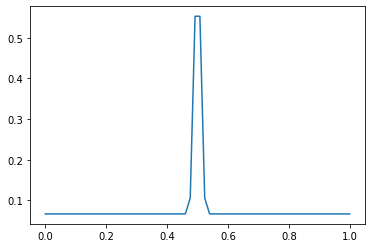

In [32]:
plt.plot(xx, Pg0[:, 0, 0])

In [33]:
importlib.reload(nm)
#Pg, rho, moment, e, time = solver(nx, ny, nz, xx, nt, Pg01D, rho01D, u01D, e01D)
#Pg, rho, moment, e, time = solver3D(domain, xx, yy, zz, nt, Pg0, rho0, u0, e0, method='FTCS')
Pg, rho, moment, e, time = solverND(domain, xx, yy, zz, nt, Pg0, rho0, u0, e0, method='FTCS')
#args = solver3D(domain, xx, yy, zz, nt, Pg0, rho0, u0, e0)
#
#
u = moment/rho

/home/astronih/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ValueError: operands could not be broadcast together with shapes (64,1,100) (64,) 

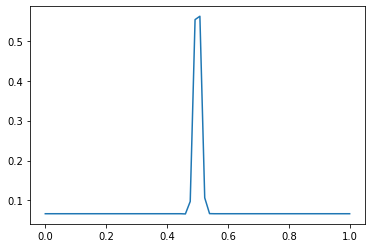

In [ ]:
plt.plot(xx, Pg[:, 0, 0, 1])

In [ ]:
t_idx = np.nanargmax(time)
plt.plot(xx, u[:, 0, 0, 0])
plt.plot(xx, u[:, 0, 0, -1])
plt.title(f't={time[-1]}')

IndexError: too many indices for array: array is 2-dimensional, but 4 were indexed

/tmp/ipykernel_4150/249374402.py:1: RuntimeWarning: invalid value encountered in divide
  u = moment/rho


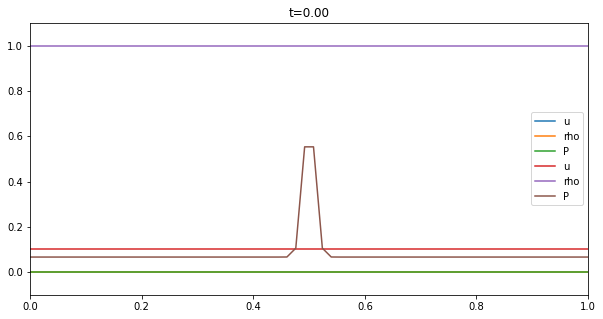

In [29]:
u = moment/rho
anim = animation(xx, time, u[:, 0, 0], rho[:, 0, 0], Pg[:, 0, 0], nt)
HTML(anim.to_jshtml())